In [317]:
# Data Wrangling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#Preprocessing
from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelBinarizer 
## !pip install imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier



#Validation packages
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV


# measurements
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score

#pycarat
#from pycaret.classification import setup
#from pycaret.classification import compare_models

# others
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## change working diretory for data uploading if necessary
## import os
## os.chdir('/rawData')

# Data Uploading and EDA

In [318]:
#### https://www.kaggle.com/harriken/predict-employee-ausentism

## available companies in the data set, i.e. company master
comp_dict = pd.read_csv('company_dictionary.csv')

## employee's votes on 'how are you today'. higher vote score, better 
votes = pd.read_csv('votes.csv')
votes['voteDate'] = pd.to_datetime(votes['voteDate'], format = '%Y-%m-%d %H:%M')
votes['year'] = votes['voteDate'].dt.year
votes['month'] = votes['voteDate'].dt.month

## 
last_part_exists = pd.read_csv('lastParticipationExists.csv')
last_part_exists['lastParticipationDate'] =  pd.to_datetime(last_part_exists['lastParticipationDate'], format = '%m/%d/%y %H:%M')

## time off records by employee
emp_absen = pd.read_csv('employeeAbsenteeism.csv')
emp_absen['from'] =  pd.to_datetime(emp_absen['from'], format = '%m/%d/%y %H:%M')
emp_absen['to'] =  pd.to_datetime(emp_absen['to'], format = '%m/%d/%y %H:%M')
emp_absen['num_days'] = (emp_absen['to'] - emp_absen['from']).dt.days
emp_absen['month'] = emp_absen['from'].dt.month
emp_absen['quarter'] = emp_absen['from'].dt.quarter

## list of all comments with number of likes/dislikes and comment category
comment_by_emp = pd.read_csv('comments_by_employees_in_anonymous_forum.csv')
comment_by_emp['commentDate'] = pd.to_datetime(comment_by_emp['commentDate'], format = '%Y-%m-%d %H:%M')
comment_by_emp['year'] = comment_by_emp['commentDate'].dt.year
comment_by_emp['month'] = comment_by_emp['commentDate'].dt.month

## employee's reactions toward the commnets
comment_inter = pd.read_csv('commentInteractions.csv')
comment_inter['actionDate'] = pd.to_datetime(comment_inter['actionDate'], format = '%Y-%m-%d %H:%M')
comment_inter['year'] = comment_inter['actionDate'].dt.year
comment_inter['month'] = comment_inter['actionDate'].dt.month

all Absenteeism happened within 1 year, which is 2018.
there are 62 different absent employees out of total 106 records.


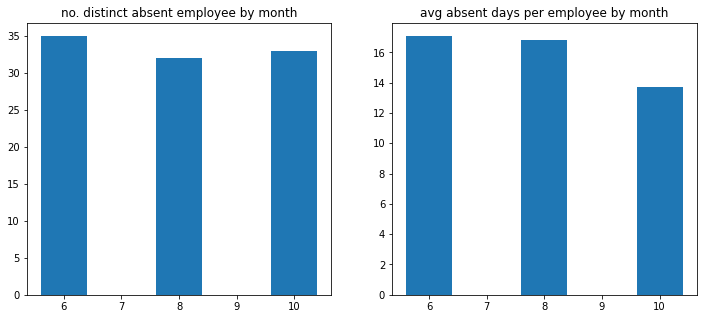

The absence records show that employees took leave mainly in Jun, Aug and Oct 2018.
The absence records do not make sense in real life situation. It seems like there was some data collection issue that only the 3 months records are collected.


In [319]:
#####################
## Y - Absenteeism ##
#####################

print('all Absenteeism happened within %d year, which is %d.' % (emp_absen['from'].dt.year.nunique(), emp_absen['from'].dt.year.mode()))
print('there are %d different absent employees out of total %d records.' % (emp_absen['employee'].nunique(), emp_absen['employee'].shape[0]))

temp1 = emp_absen.groupby(['month'])['employee'].nunique().to_frame().reset_index()
temp2 = emp_absen.groupby(['month'])['num_days'].mean().to_frame().reset_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
ax1.bar(temp1['month'].values, temp1['employee'].values)
ax1.set_title('no. distinct absent employee by month')
ax2.bar(temp2['month'].values, temp2['num_days'].values)
ax2.set_title('avg absent days per employee by month')
plt.show()

print('The absence records show that employees took leave mainly in Jun, Aug and Oct 2018.')
print('The absence records do not make sense in real life situation. It seems like there was some data collection issue that only the 3 months records are collected.')


### some modeling ideas   
1. since all absenteeism happened in 2018 (and the 3 months), shall we only consider 2018 (and one month ahead of those 3 months) records in other dataset?
2. we may analysis by month by employee information and set some benchmarking (e.g the avg or median days of absence per employee) as absent and non absent?

In [320]:
print('most of the absence reasons are common sickness. however, workplace accident seems to be significantly high in Oct')
pd.pivot_table(emp_absen, values = 'num_days', index = 'month', columns = 'reason', aggfunc = np.sum).reset_index()

most of the absence reasons are common sickness. however, workplace accident seems to be significantly high in Oct


reason,month,Common sickness or accident not related to the job,Long term sick leave,Non job related sickness,Workplace accident
0,6,551.0,29.0,29.0,6.0
1,8,471.0,60.0,NaN,7.0
2,10,409.0,57.0,NaN,55.0


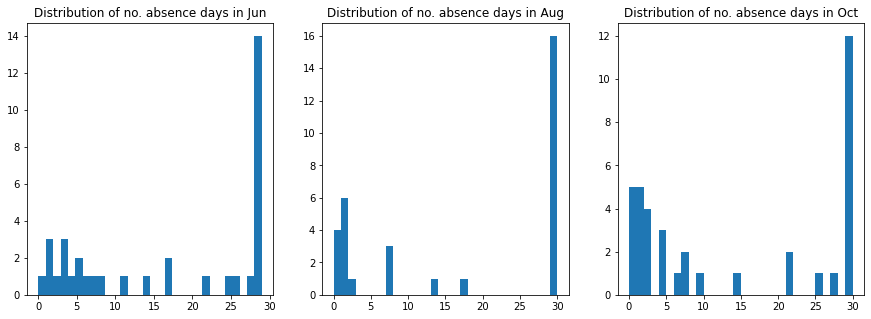

The graphs look pretty reasonable if we assume only Jun, Aug and Oct absence records were collected successfully.
So in order to build a sound forecasting model, we can use the employee activities in May, Jul and Sept to learn their absenteeism in Jun, Aug and Oct respectively.


In [321]:
temp3 = emp_absen[emp_absen['month'] == 6]
temp4 = emp_absen[emp_absen['month'] == 8]
temp5 = emp_absen[emp_absen['month'] == 10]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.hist(temp3['num_days'].values, bins = 30)
ax1.set_title('Distribution of no. absence days in Jun')
ax2.hist(temp4['num_days'].values, bins = 30)
ax2.set_title('Distribution of no. absence days in Aug')
ax3.hist(temp5['num_days'].values, bins = 30)
ax3.set_title('Distribution of no. absence days in Oct')
plt.show()

print('The graphs look pretty reasonable if we assume only Jun, Aug and Oct absence records were collected successfully.')
print('So in order to build a sound forecasting model, we can use the employee activities in May, Jul and Sept to learn their absenteeism in Jun, Aug and Oct respectively.')

In [322]:
# convert the dataframe into a proper Y-like dataframe, i.e. employee id - month - label
Y_temp = pd.merge(emp_absen, temp2.rename(columns = {'num_days': 'ave_days'}), how = 'left')
Y_temp['Absence'] = Y_temp['num_days'] > 2 # Y_temp['ave_days']    ## open to change the benchmarking here ##
Y = Y_temp[['employee', 'month', 'Absence']]
Y.head()

,employee,month,Absence
0,19Q,10,True
1,NY3,10,True
2,qKO,10,True
3,qKO,10,True
4,2wx,10,True


In [323]:
###############
## X - Votes ##
###############
votes_X = votes[votes['year'] == 2018]
votes_X = votes_X[votes_X['month'].isin([5,7,9])].reset_index(drop = True)
votes_X = votes_X.groupby(['employee', 'month'])['vote'].agg(['mean', 'count']).reset_index()
votes_X.columns = ['employee', 'month', 'mean_votes_score', 'no_of_votes']
votes_X['month'] = votes_X['month'] + 1
votes_X.head()

,employee,month,mean_votes_score,no_of_votes
0,13L,6,1.0,25
1,13L,8,1.0,19
2,13L,10,1.0,22
3,17r,6,3.0,1
4,17r,8,2.0,27


In [324]:
########################### 
## X - Original Comments ##
###########################
comment_X = comment_by_emp[comment_by_emp['year'] == 2018]
comment_X = comment_X[comment_X['month'].isin([5,7,9])].reset_index(drop = True)
comment_X['counter'] = 1

comment_temp_X_1 = pd.pivot_table(comment_X, values = 'counter', index = ['employee', 'month'], columns = 'feedbackType', aggfunc = np.sum).reset_index().fillna(0)
comment_temp_X_2 = comment_X.groupby(['employee', 'month'])['likes', 'dislikes'].sum().reset_index()
commnet_X = pd.merge(comment_temp_X_1, comment_temp_X_2, how = 'left')
commnet_X.columns = ['employee', 'month', 'congrats_num', 'criticism_num', 'information_num', 'other_num', 'suggestion_num', 'total_likes', 'total_dislikes']
commnet_X['month'] = commnet_X['month'] + 1
commnet_X.head()

,employee,month,congrats_num,criticism_num,information_num,other_num,suggestion_num,total_likes,total_dislikes
0,19Q,6,1.0,0.0,0.0,0.0,0.0,32,7
1,19Q,8,0.0,0.0,2.0,0.0,0.0,47,8
2,19Q,10,0.0,0.0,1.0,4.0,0.0,27,6
3,1EY,10,0.0,0.0,0.0,2.0,0.0,0,0
4,1YL,10,0.0,0.0,0.0,1.0,0.0,0,0


In [325]:
############################## 
## X - Comments Interaction ##
##############################
inter_X = comment_inter[comment_inter['year'] == 2018]
inter_X = inter_X[inter_X['month'].isin([5,7,9])].reset_index(drop = True)
inter_temp_X = pd.merge(inter_X, comment_by_emp[['commentId', 'feedbackType']], how = 'left')
inter_temp_X['Agree'] = [1 if i == 1 else 0 for i in inter_temp_X['interaction']]
inter_temp_X['Disagree'] = [1 if i == -1 else 0 for i in inter_temp_X['interaction']]

inter_X1 = pd.pivot_table(inter_temp_X, values = 'Agree', index = ['employee', 'month'], columns = 'feedbackType', aggfunc = np.sum).reset_index().fillna(0)
inter_X1.columns = ['employee', 'month', 'congrats_agree_num', 'information_agree_num', 'other_agree_num', 'suggestion_agree_num']
inter_X2 = pd.pivot_table(inter_temp_X, values = 'Disagree', index = ['employee', 'month'], columns = 'feedbackType', aggfunc = np.sum).reset_index().fillna(0)
inter_X2.columns = ['employee', 'month', 'congrats_disagree_num', 'information_disagree_num', 'other_disagree_num', 'suggestion_disagree_num']

inter_X = pd.merge(inter_X1, inter_X2, how = 'left')
inter_X['month'] = inter_X['month'] + 1

inter_X.head()

,employee,month,congrats_agree_num,information_agree_num,other_agree_num,suggestion_agree_num,congrats_disagree_num,information_disagree_num,other_disagree_num,suggestion_disagree_num
0,13L,6,7.0,28.0,0.0,0.0,1.0,1.0,1.0,1.0
1,13L,8,1.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0
2,13L,10,0.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0
3,17r,8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17r,10,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [326]:
################################# 
## X - lastParticipationExists ##
################################# 

lastParticipationExists_v2 = last_part_exists.copy()
lastParticipationExists_v2['Ceuta'] = lastParticipationExists_v2['timezone'] == 'Africa/Ceuta'
lastParticipationExists_v2['Ceuta'] = lastParticipationExists_v2['Ceuta'].astype(int)
lastParticipationExists_v2['chicago'] = lastParticipationExists_v2['timezone'] == 'America/Chicago'
lastParticipationExists_v2['chicago'] = lastParticipationExists_v2['chicago'].astype(int)
lastParticipationExists_v2['amsterdam'] = lastParticipationExists_v2['timezone'] == 'Europe/Amsterdam'
lastParticipationExists_v2['amsterdam'] = lastParticipationExists_v2['amsterdam'].astype(int)
lastParticipationExists_v2['berlin'] = lastParticipationExists_v2['timezone'] == 'Europe/Berlin'
lastParticipationExists_v2['berlin'] = lastParticipationExists_v2['berlin'].astype(int)
lastParticipationExists_v2['madrid'] = lastParticipationExists_v2['timezone'] == 'Europe/Madrid'
lastParticipationExists_v2['madrid'] = lastParticipationExists_v2['madrid'].astype(int)
lastParticipationExists_v2['moscow'] = lastParticipationExists_v2['timezone'] == 'Europe/Moscow'
lastParticipationExists_v2['moscow'] = lastParticipationExists_v2['moscow'].astype(int)
lastParticipationExists_v2.head()

,employee,companyAlias,numVotes,lastParticipationDate,timezone,stillExists,deletedOn,Ceuta,chicago,amsterdam,berlin,madrid,moscow
0,l8,C1,285,2019-03-08 01:03:00,Europe/Madrid,True,NaN,0,0,0,0,1,0
1,Xv,C1,143,2018-04-21 02:04:00,Europe/Berlin,True,NaN,0,0,0,1,0,0
2,w7,C1,381,2019-03-11 01:03:00,Europe/Madrid,True,NaN,0,0,0,0,1,0
3,jE,C1,173,2019-03-01 01:03:00,Europe/Madrid,True,NaN,0,0,0,0,1,0
4,QP,C1,312,2019-03-08 01:03:00,Europe/Berlin,True,NaN,0,0,0,1,0,0


In [327]:
print('Latest participated: ', max(lastParticipationExists_v2['lastParticipationDate']))
print('First participated: ', min(lastParticipationExists_v2['lastParticipationDate']))

Latest participated:  2019-03-11 01:03:00
First participated:  2017-05-06 02:05:00


In [328]:
lastParticipationExists_v2['LatestParticipatedDate'] = max(lastParticipationExists_v2['lastParticipationDate'])
lastParticipationExists_v2['DaysSincelastParticipationDate'] = lastParticipationExists_v2['LatestParticipatedDate'] - lastParticipationExists_v2['lastParticipationDate']
lastParticipationExists_v2['days_since_last_participated'] = lastParticipationExists_v2['DaysSincelastParticipationDate'].apply(lambda x: x.days)

lastParticipationExists_v2.head()

,employee,companyAlias,numVotes,lastParticipationDate,timezone,stillExists,deletedOn,Ceuta,chicago,amsterdam,berlin,madrid,moscow,LatestParticipatedDate,DaysSincelastParticipationDate,days_since_last_participated
0,l8,C1,285,2019-03-08 01:03:00,Europe/Madrid,True,NaN,0,0,0,0,1,0,2019-03-11 01:03:00,3 days 00:00:00,3.0
1,Xv,C1,143,2018-04-21 02:04:00,Europe/Berlin,True,NaN,0,0,0,1,0,0,2019-03-11 01:03:00,323 days 22:59:00,323.0
2,w7,C1,381,2019-03-11 01:03:00,Europe/Madrid,True,NaN,0,0,0,0,1,0,2019-03-11 01:03:00,0 days 00:00:00,0.0
3,jE,C1,173,2019-03-01 01:03:00,Europe/Madrid,True,NaN,0,0,0,0,1,0,2019-03-11 01:03:00,10 days 00:00:00,10.0
4,QP,C1,312,2019-03-08 01:03:00,Europe/Berlin,True,NaN,0,0,0,1,0,0,2019-03-11 01:03:00,3 days 00:00:00,3.0


#### combining Xs and Y

In [329]:
X1 = pd.merge(votes_X, commnet_X,  how = 'left')
print(X1.shape)
X = pd.merge(X1, inter_X, how = 'left')
print(X.shape)
final1 = pd.merge(X, Y, how = 'left')
print(final1.shape)
final2 = pd.merge(final1, lastParticipationExists_v2, left_on = 'employee', right_on = 'employee',  how = 'left')
print(final2.shape)
final = final2.copy()


final['Absence'].fillna('False', inplace = True)
#final = final.drop(columns = ['employee', 'month'], axis = 1)
final['Absence'] = [1 if i == True else 0 for i in final['Absence']]
final = final[final['stillExists'] == True]

################################################# 
## X - likeability and relative_mean_score ##
################################################  

print(final.shape)

final['total_likes'].value_counts()

final['likeability'] = final['total_likes'] != 0
final['likeability'] = final['likeability'].astype(int)
final['likeability'] 

final.loc[final['total_likes']==0, 'likeability'] = 0 
final.loc[final['total_likes']!=0, 'likeability'] = final['total_likes']/(final['total_likes'] + final['total_dislikes'])

final['total_num_of_feedback'] = final['congrats_num'] + final['criticism_num'] + final['information_num'] + final['other_num'] + final['suggestion_num']
final['total_num_of_feedback']

final['relative_mean_score'] = final['mean_votes_score']/np.mean(final['mean_votes_score'])

(897, 11)
(897, 19)
(902, 20)
(902, 35)
(836, 35)


In [330]:
# choose final 
final = final[['no_of_votes', 'congrats_num', 'criticism_num', 'information_num', 'other_num',
       'suggestion_num', 'total_likes', 'total_dislikes', 'congrats_agree_num', 'information_agree_num', 'other_agree_num', 
        'suggestion_agree_num', 'congrats_disagree_num', 'information_disagree_num', 'other_disagree_num', 
        'suggestion_disagree_num', 'deletedOn', 'Ceuta', 'chicago', 'amsterdam', 'berlin', 'madrid','moscow','Absence', 
               'likeability', 'total_num_of_feedback', 'relative_mean_score']]
        
final = final.fillna(0)

In [331]:
final.columns

Index(['no_of_votes', 'congrats_num', 'criticism_num', 'information_num',
       'other_num', 'suggestion_num', 'total_likes', 'total_dislikes',
       'congrats_agree_num', 'information_agree_num', 'other_agree_num',
       'suggestion_agree_num', 'congrats_disagree_num',
       'information_disagree_num', 'other_disagree_num',
       'suggestion_disagree_num', 'deletedOn', 'Ceuta', 'chicago', 'amsterdam',
       'berlin', 'madrid', 'moscow', 'Absence', 'likeability',
       'total_num_of_feedback', 'relative_mean_score'],
      dtype='object')

In [332]:
print('Most of the employees participated in the dalily votes. However, very few of them did posting while some of them interacted with postings.')
final.describe()

Most of the employees participated in the dalily votes. However, very few of them did posting while some of them interacted with postings.


,no_of_votes,congrats_num,criticism_num,information_num,other_num,suggestion_num,total_likes,total_dislikes,congrats_agree_num,information_agree_num,...,Ceuta,chicago,amsterdam,berlin,madrid,moscow,Absence,likeability,total_num_of_feedback,relative_mean_score
count,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,...,836.000000,836.0,836.0,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000,836.000000
mean,19.037081,0.052632,0.002392,0.387560,0.209330,0.081340,12.582536,4.236842,1.610048,10.288278,...,0.020335,0.0,0.0,0.057416,0.921053,0.001196,0.075359,0.164266,0.733254,1.000000
std,9.010829,0.280471,0.048882,1.158375,0.933968,0.395285,35.338353,13.085399,2.446769,14.333476,...,0.141228,0.0,0.0,0.232776,0.269818,0.034586,0.264128,0.322359,1.744629,0.293991
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.351049
25%,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.798636
50%,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,...,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.053147
75%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,14.250000,...,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.155064
max,31.000000,3.000000,1.000000,13.000000,10.000000,6.000000,347.000000,137.000000,19.000000,102.000000,...,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,17.000000,1.404196


In [333]:
print('the data is extremely unbalanced; we may need to re-sample/balance the dataset before modeling the model.')
#Class Imbalance
final['Absence'].value_counts()/(final['Absence'].value_counts()[0] + final['Absence'].value_counts()[1])

the data is extremely unbalanced; we may need to re-sample/balance the dataset before modeling the model.


0    0.924641
1    0.075359
Name: Absence, dtype: float64

In [334]:
final.head()

,no_of_votes,congrats_num,criticism_num,information_num,other_num,suggestion_num,total_likes,total_dislikes,congrats_agree_num,information_agree_num,...,Ceuta,chicago,amsterdam,berlin,madrid,moscow,Absence,likeability,total_num_of_feedback,relative_mean_score
0,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,28.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
1,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
2,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.053147
4,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0.0,0.0,0.702098


# Exploratory Data Analysis

In [335]:
final['suggestion_agree_num'].value_counts()

0.0     414
1.0     133
2.0      97
3.0      51
4.0      45
5.0      26
6.0      22
7.0      12
8.0       9
9.0       8
10.0      6
11.0      5
13.0      3
17.0      1
18.0      1
16.0      1
12.0      1
14.0      1
Name: suggestion_agree_num, dtype: int64

In [336]:
final

,no_of_votes,congrats_num,criticism_num,information_num,other_num,suggestion_num,total_likes,total_dislikes,congrats_agree_num,information_agree_num,...,Ceuta,chicago,amsterdam,berlin,madrid,moscow,Absence,likeability,total_num_of_feedback,relative_mean_score
0,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,28.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
1,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
2,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.053147
4,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0.0,0.0,0.702098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.404196
897,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0,0,0,0,1,0,0,0.0,0.0,0.737203
899,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.053147
900,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.404196


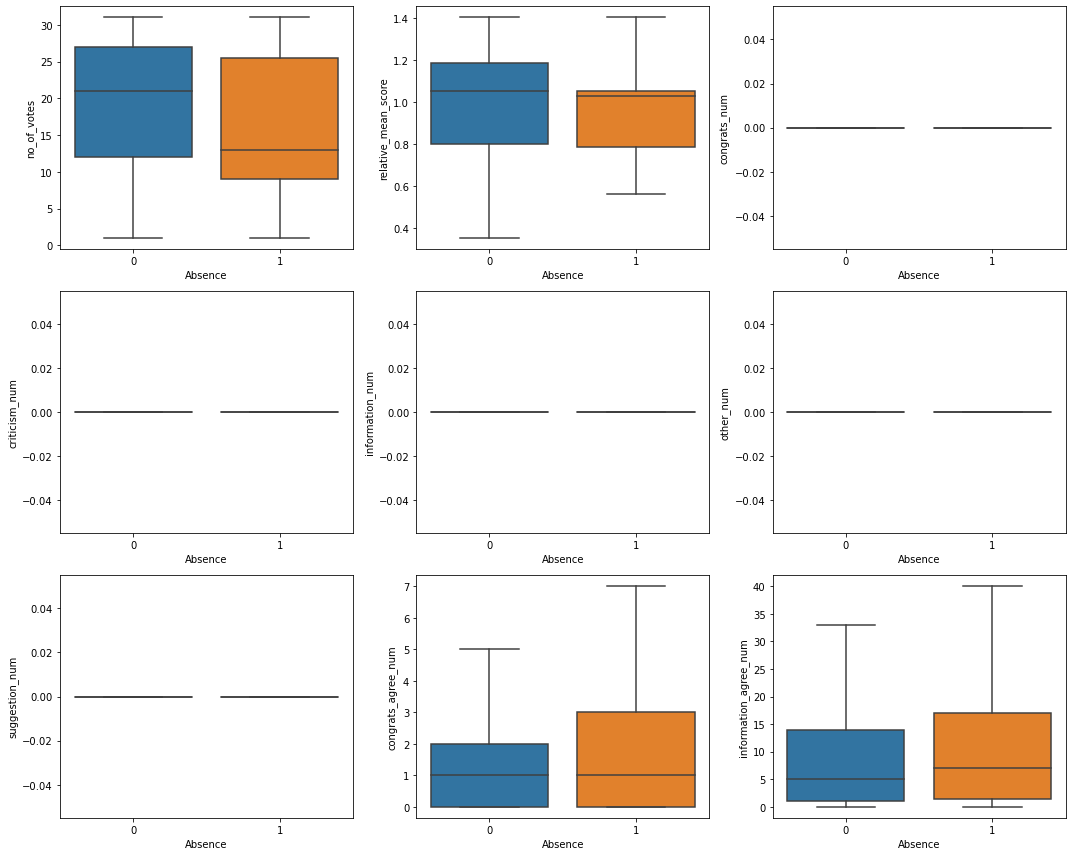

In [337]:
iter_cols = ['no_of_votes', 'relative_mean_score', 'congrats_num',
 'criticism_num',
 'information_num',
 'other_num',
 'suggestion_num',
 'congrats_agree_num',
 'information_agree_num']


fig = plt.figure(num = 98, figsize = (15, 12))
for i in range(0, 9):
    ax1 = fig.add_subplot(3, 3, i + 1)
    _ = sns.boxplot(x = "Absence", y = iter_cols[i], data = final, ax = ax1, showfliers = False)
    _ = plt.tight_layout()
plt.show()

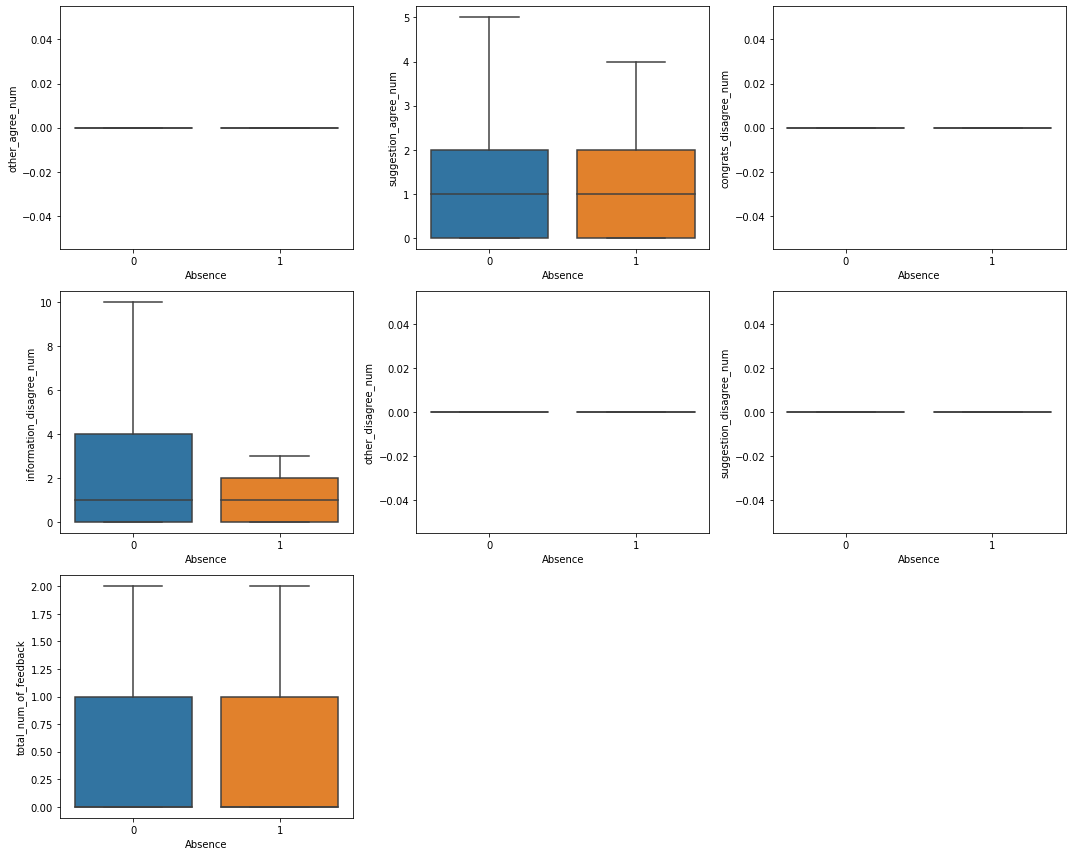

In [338]:
 iter_cols = ['other_agree_num',
 'suggestion_agree_num',
 'congrats_disagree_num',
 'information_disagree_num',
 'other_disagree_num',
 'suggestion_disagree_num',
 'total_num_of_feedback']

fig = plt.figure(num = 98, figsize = (15, 12))
for i in range(0, 7):
    ax1 = fig.add_subplot(3, 3, i + 1)
    _ = sns.boxplot(x = "Absence", y = iter_cols[i], data = final, ax = ax1, showfliers = False)
    _ = plt.tight_layout()
plt.show()

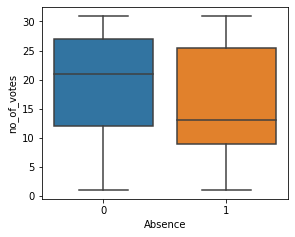

In [339]:
# no_of_votes
fig = plt.figure(num = 98, figsize = (15, 12))
ax1 = fig.add_subplot(3, 3,1)
sns.boxplot(x = "Absence", y = 'no_of_votes', data = final, ax = ax1, showfliers = False)
plt.show()

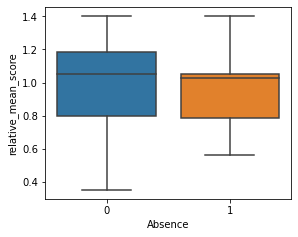

In [340]:
# relative_mean_score
fig = plt.figure(num = 98, figsize = (15, 12))
ax1 = fig.add_subplot(3, 3,1)
sns.boxplot(x = "Absence", y = 'relative_mean_score', data = final, ax = ax1, showfliers = False)
plt.show()

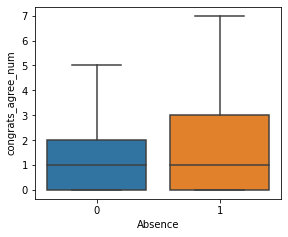

In [341]:
# 'congrats_agree_num'
fig = plt.figure(num = 98, figsize = (15, 12))
ax1 = fig.add_subplot(3, 3,1)
sns.boxplot(x = "Absence", y = 'congrats_agree_num', data = final, ax = ax1, showfliers = False)
plt.show()

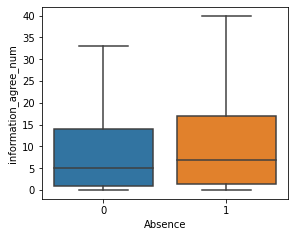

In [342]:
# 'information_agree_num'
fig = plt.figure(num = 98, figsize = (15, 12))
ax1 = fig.add_subplot(3, 3,1)
sns.boxplot(x = "Absence", y = 'information_agree_num', data = final, ax = ax1, showfliers = False)
plt.show()

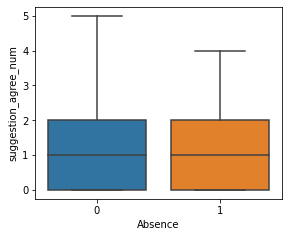

In [343]:
# 'suggestion_agree_num'
fig = plt.figure(num = 98, figsize = (15, 12))
ax1 = fig.add_subplot(3, 3,1)
sns.boxplot(x = "Absence", y = 'suggestion_agree_num', data = final, ax = ax1, showfliers = False)
plt.show()

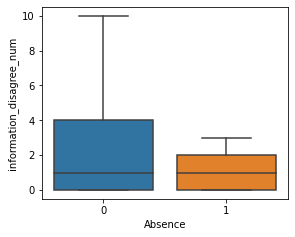

In [344]:
# 'information_disagree_num'
fig = plt.figure(num = 98, figsize = (15, 12))
ax1 = fig.add_subplot(3, 3,1)
sns.boxplot(x = "Absence", y = 'information_disagree_num', data = final, ax = ax1, showfliers = False)
plt.show()

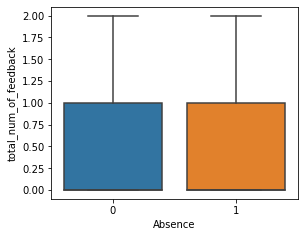

In [345]:
# 'total_num_of_feedback'
fig = plt.figure(num = 98, figsize = (15, 12))
ax1 = fig.add_subplot(3, 3,1)
sns.boxplot(x = "Absence", y = 'total_num_of_feedback', data = final, ax = ax1, showfliers = False)
plt.show()

In [346]:
# for i in range(10, 15):
#     ax1 = fig.add_subplot(3, 3, i + 1)
#     _ = sns.boxplot(x = "Absence", y = iter_cols[i], data = final, ax = ax1, showfliers = False)
#     _ = plt.tight_layout()
# plt.show()

<AxesSubplot:xlabel='relative_mean_score', ylabel='Density'>

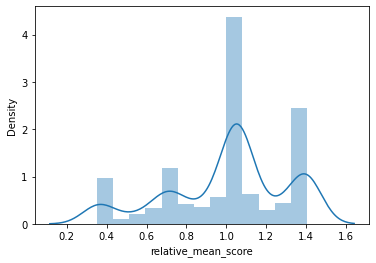

In [347]:
sns.distplot(final[final['Absence']==0]['relative_mean_score'])

<AxesSubplot:xlabel='relative_mean_score', ylabel='Density'>

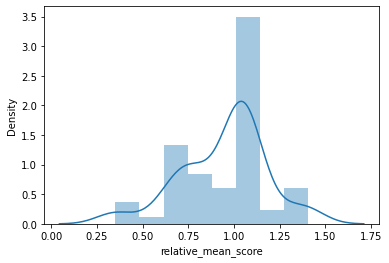

In [348]:
sns.distplot(final[final['Absence']==1]['relative_mean_score'])

<AxesSubplot:xlabel='no_of_votes', ylabel='Density'>

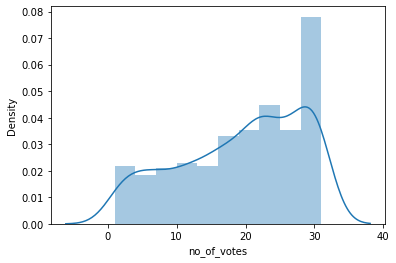

In [349]:
sns.distplot(final[final['Absence']==0]['no_of_votes'])

<AxesSubplot:xlabel='no_of_votes', ylabel='Density'>

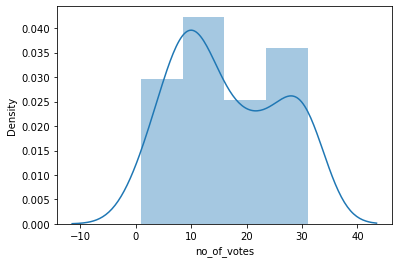

In [350]:
sns.distplot(final[final['Absence']==1]['no_of_votes'])

<AxesSubplot:xlabel='total_likes', ylabel='Density'>

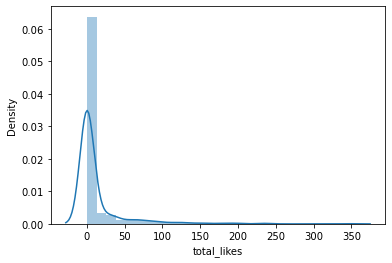

In [351]:
sns.distplot(final[final['Absence']==0]['total_likes'])

<AxesSubplot:xlabel='total_likes', ylabel='Density'>

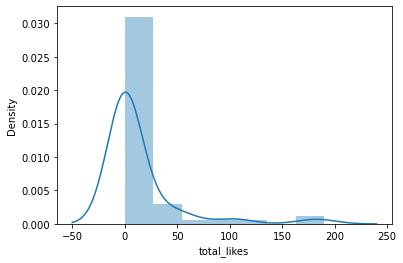

In [352]:
sns.distplot(final[final['Absence']==1]['total_likes'])

<AxesSubplot:xlabel='total_dislikes', ylabel='Density'>

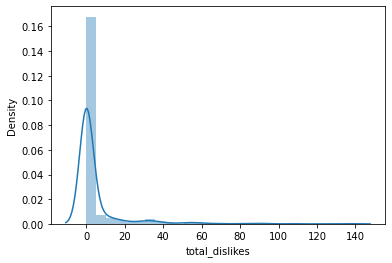

In [353]:
sns.distplot(final[final['Absence']==0]['total_dislikes'])

<AxesSubplot:xlabel='total_dislikes', ylabel='Density'>

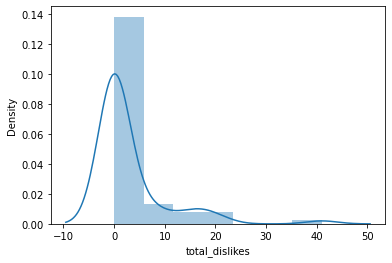

In [354]:
sns.distplot(final[final['Absence']==1]['total_dislikes'])

<AxesSubplot:xlabel='congrats_agree_num', ylabel='Density'>

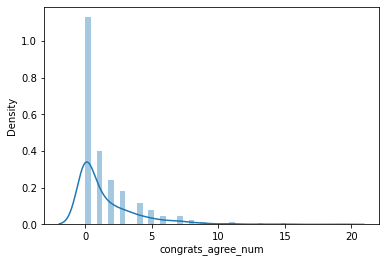

In [355]:
sns.distplot(final[final['Absence']==0]['congrats_agree_num'])

<AxesSubplot:xlabel='congrats_agree_num', ylabel='Density'>

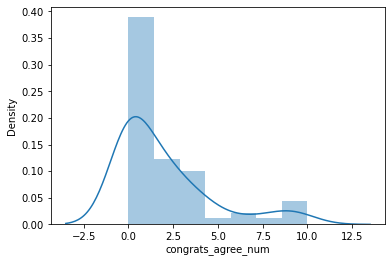

In [356]:
sns.distplot(final[final['Absence']==1]['congrats_agree_num'])

<AxesSubplot:xlabel='congrats_disagree_num', ylabel='Density'>

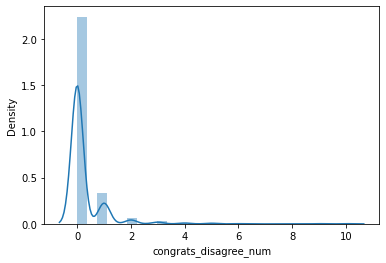

In [357]:
sns.distplot(final[final['Absence']==0]['congrats_disagree_num'])

<AxesSubplot:xlabel='congrats_disagree_num', ylabel='Density'>

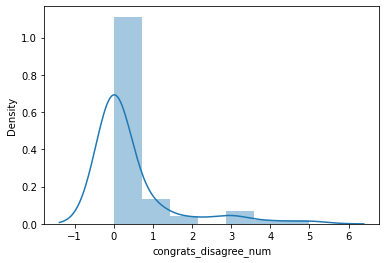

In [358]:
sns.distplot(final[final['Absence']==1]['congrats_disagree_num'])

<AxesSubplot:xlabel='suggestion_agree_num', ylabel='Density'>

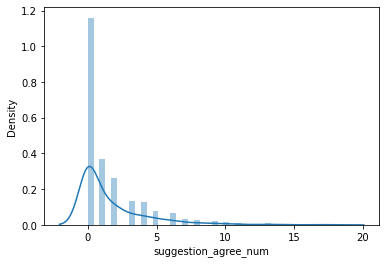

In [359]:
sns.distplot(final[final['Absence']==0]['suggestion_agree_num'])

<AxesSubplot:xlabel='suggestion_agree_num', ylabel='Density'>

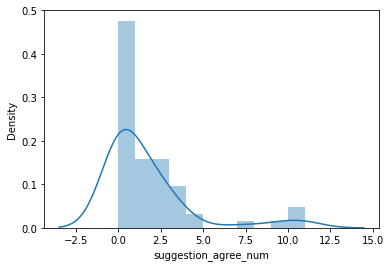

In [360]:
sns.distplot(final[final['Absence']==1]['suggestion_agree_num'])

<AxesSubplot:xlabel='suggestion_disagree_num', ylabel='Density'>

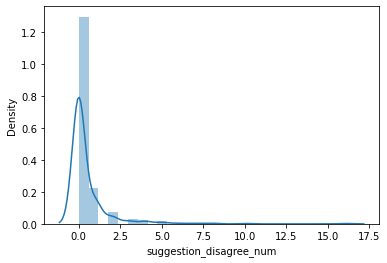

In [361]:
sns.distplot(final[final['Absence']==0]['suggestion_disagree_num'])

<AxesSubplot:xlabel='suggestion_disagree_num', ylabel='Density'>

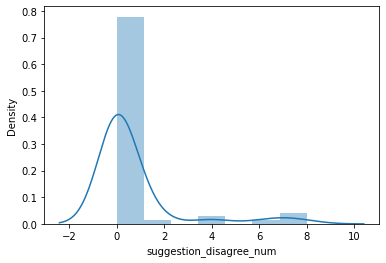

In [362]:
sns.distplot(final[final['Absence']==1]['suggestion_disagree_num'])

<AxesSubplot:xlabel='information_agree_num', ylabel='Density'>

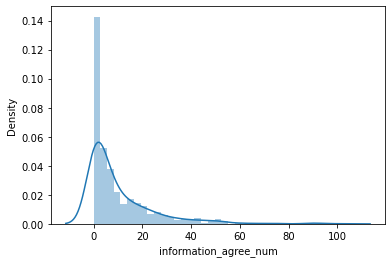

In [363]:
sns.distplot(final[final['Absence']==0]['information_agree_num'])

<AxesSubplot:xlabel='information_agree_num', ylabel='Density'>

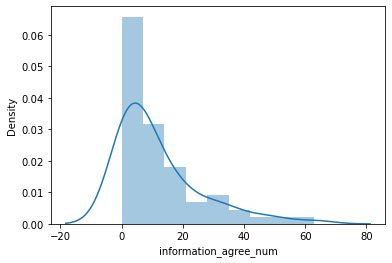

In [364]:
sns.distplot(final[final['Absence']==1]['information_agree_num'])

<AxesSubplot:xlabel='information_disagree_num', ylabel='Density'>

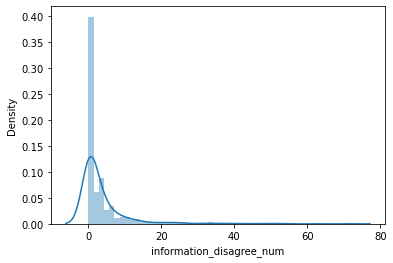

In [365]:
sns.distplot(final[final['Absence']==0]['information_disagree_num'])

<AxesSubplot:xlabel='information_disagree_num', ylabel='Density'>

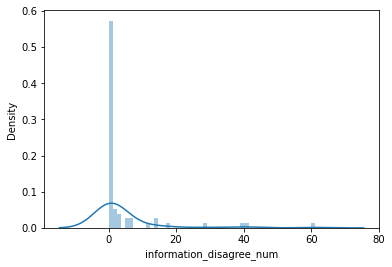

In [366]:
sns.distplot(final[final['Absence']==1]['information_disagree_num'])

In [367]:
X

,employee,month,mean_votes_score,no_of_votes,congrats_num,criticism_num,information_num,other_num,suggestion_num,total_likes,total_dislikes,congrats_agree_num,information_agree_num,other_agree_num,suggestion_agree_num,congrats_disagree_num,information_disagree_num,other_disagree_num,suggestion_disagree_num
0,13L,6,1.0,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,28.0,0.0,0.0,1.0,1.0,1.0,1.0
1,13L,8,1.0,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,4.0,1.0,1.0,0.0,1.0,0.0,0.0
2,13L,10,1.0,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0
3,17r,6,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17r,8,2.0,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
892,zMY,10,2.1,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5.0,0.0,0.0,0.0,2.0,0.0,0.0
893,zR7,10,4.0,24,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,18.0,0.0,4.0,0.0,4.0,1.0,1.0
894,zxx,6,3.0,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
895,zxx,8,4.0,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


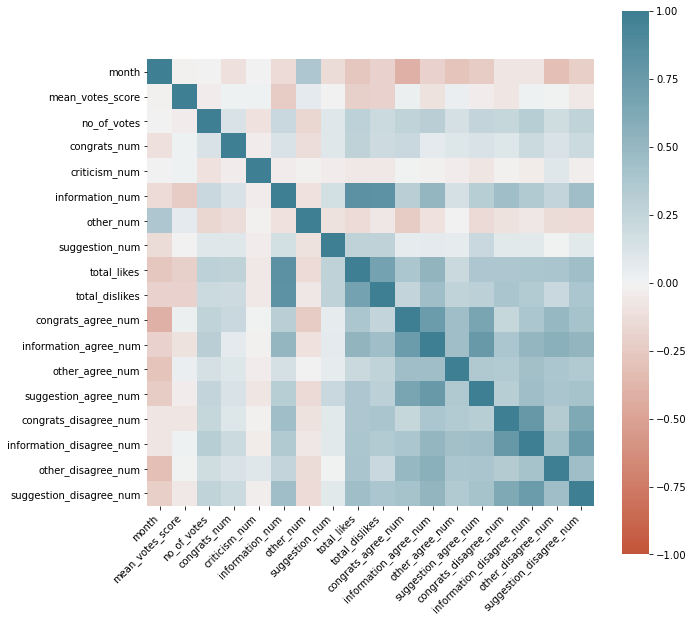

In [368]:
#Feature Correlation

corr = X.corr()

fig, ax = plt.subplots(figsize=(10,10)) 

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# Modelling

# Absent Tagging: more than 2 days - SVM 

In [369]:
################################
## Train Test Split Approach  ##
################################
X = final.drop(columns = ['Absence'], axis = 1)
y = final['Absence']
X_stand = scale(X)
X_train, X_test, y_train, y_test = train_test_split(X_stand, y, test_size = 0.3, random_state = 2823)
over_sampler = RandomOverSampler(random_state=42, sampling_strategy=0.1)
X_res, y_res = over_sampler.fit_resample(X_train, y_train)
# oversample = SMOTE(random_state=42, sampling_strategy=0.1)
# X_res, y_res = oversample.fit_resample(X_train, y_train)

In [370]:
#svc_model = SVC(C = 1.3, kernel = 'poly', random_state = 2328) 
#kernel = poly
svc_model_poly = SVC(kernel = 'poly') #C = 1.3, kernel = 'poly', random_state = 2328) 
svc_model_poly.fit(X_res, y_res)
svc_model_poly.score(X_test, y_test)
prediction_poly = svc_model_poly.predict(X_test)

print('Accuracy:', accuracy_score(y_test, prediction_poly))
print('F1 score:', f1_score(y_test, prediction_poly))
print('Recall:', recall_score(y_test, prediction_poly))
print('Precision:', precision_score(y_test, prediction_poly))
#print('\n clasification report:\n', classification_report(y_test,prediction))
print('\n confussion matrix:\n',confusion_matrix(y_test, prediction_poly))

Accuracy: 0.8884462151394422
F1 score: 0.0
Recall: 0.0
Precision: 0.0

 confussion matrix:
 [[223   4]
 [ 24   0]]


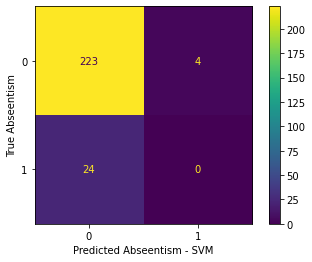

In [371]:
plot_confusion_matrix(svc_model_poly, X_test, y_test) 
plt.xlabel('Predicted Abseentism - SVM')
plt.ylabel('True Abseentism')
plt.show()

Text(0.5, 0, 'Permutation Importance - SVM_poly model')

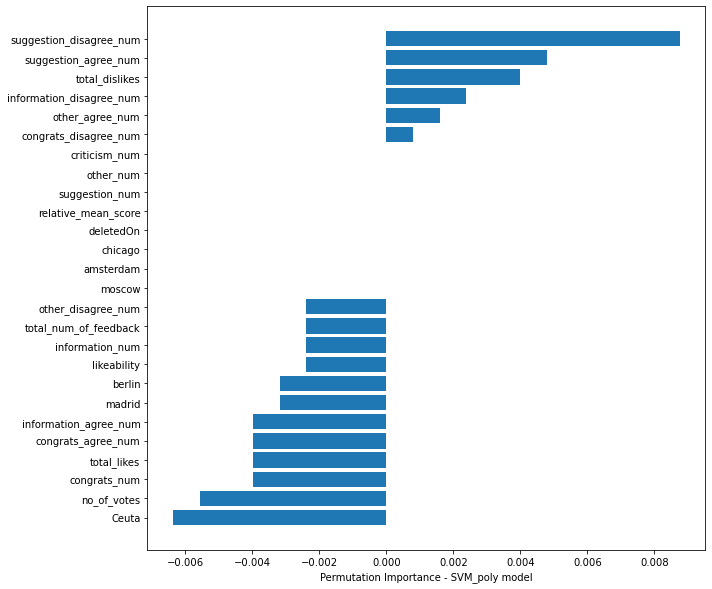

In [372]:
perm_importance = permutation_importance(svc_model_poly, X_test, y_test)
feature_names = ['no_of_votes', 'congrats_num', 'criticism_num', 'information_num', 'other_num',
       'suggestion_num', 'total_likes', 'total_dislikes', 'congrats_agree_num', 'information_agree_num', 'other_agree_num', 
        'suggestion_agree_num', 'congrats_disagree_num', 'information_disagree_num', 'other_disagree_num', 
        'suggestion_disagree_num', 'Ceuta', 'chicago', 'amsterdam', 'berlin', 'madrid','moscow', 
               'likeability', 'total_num_of_feedback', 'relative_mean_score']
features = np.array(feature_names)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(10,10))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], height=0.8)
plt.xlabel("Permutation Importance - SVM_poly model")


In [373]:
# K fold cross validation
svmModel = SVC(kernel = 'poly')
cv_method = KFold(n_splits = 10, shuffle = True, random_state = 2823)

svm_acc = np.mean(cross_val_score(svmModel, X, y ,cv = cv_method, scoring = 'accuracy'))
svm_recall = np.mean(cross_val_score(svmModel, X, y ,cv = cv_method, scoring = 'recall'))
svm_precision = np.mean(cross_val_score(svmModel, X, y ,cv = cv_method, scoring = 'precision'))


print('The Cross Validation Accuracy for SVM Model is ', svm_acc)
print('The Cross Validation Recall for SVM Model is ', svm_recall)
print('The Cross Validation Recall for SVM Model is ', svm_precision)

The Cross Validation Accuracy for SVM Model is  0.9235513482501434
The Cross Validation Recall for SVM Model is  0.0
The Cross Validation Recall for SVM Model is  0.0


# Absent Tagging: more than 2 days - Random Forest Classifier 

In [374]:
df = final.copy()

X = final.drop(columns = ['Absence'], axis = 1)
y = final['Absence']

X_stand = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_stand, y, test_size = 0.3, random_state = 0)
X_test_df = pd.DataFrame(X_stand)
X_test_df.columns = X.columns
X_test_df

oversample = RandomOverSampler(random_state=42, sampling_strategy=1)
#oversample = SMOTE(random_state=42, sampling_strategy=0.7)
X_res, y_res = oversample.fit_resample(X_train, y_train)

clf=RandomForestClassifier()

clf.fit(X_res, y_res)
y_pred=clf.predict(X_test)

import shap
explainer = shap.TreeExplainer(clf)
#svm_explainer = shap.TreeExplainer(clf.predict,X_test)
shap_values = explainer.shap_values(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
#print('\n clasification report:\n', classification_report(y_test,y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))


Accuracy: 0.8884462151394422
Recall: 0.15
Precision: 0.21428571428571427

 confussion matrix:
 [[220  11]
 [ 17   3]]


In [375]:
#Class Imbalance
final['Absence'].value_counts()/(final['Absence'].value_counts()[0] + final['Absence'].value_counts()[1])

0    0.924641
1    0.075359
Name: Absence, dtype: float64

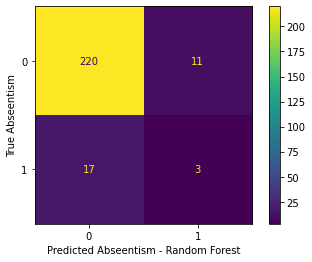

In [376]:
#confusion matrix
plot_confusion_matrix(clf, X_test, y_test) 
plt.xlabel('Predicted Abseentism - Random Forest')
plt.ylabel('True Abseentism')
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

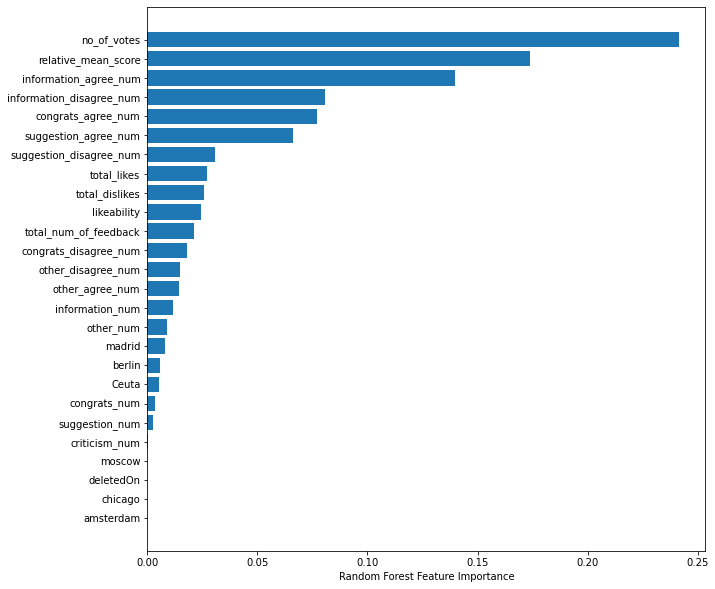

In [377]:
# Feature Importance
clf.feature_importances_
sorted_features = clf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(X.columns[sorted_features],clf.feature_importances_[sorted_features], height=0.8)

plt.xlabel("Random Forest Feature Importance")

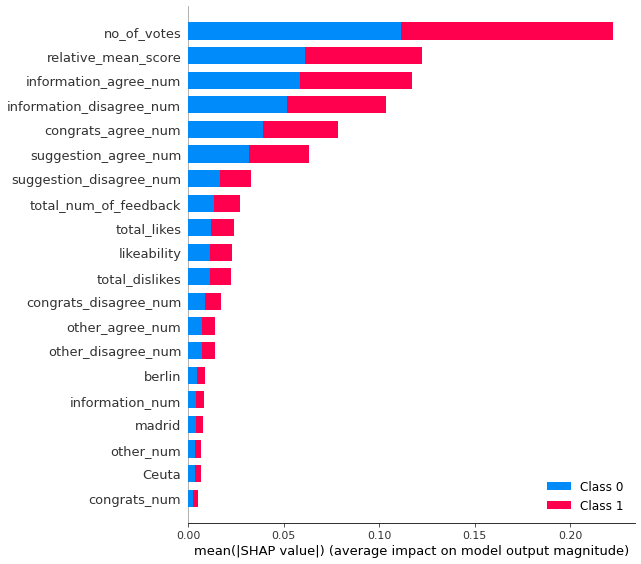

In [378]:
#shap values
shap.summary_plot(shap_values, X_test_df)

In [379]:
# K fold cross validation
RFModel=RandomForestClassifier()
cv_method = KFold(n_splits = 10, shuffle = True, random_state = 2823)

svm_acc = np.mean(cross_val_score(RFModel, X, y ,cv = cv_method, scoring = 'accuracy'))
svm_recall = np.mean(cross_val_score(RFModel, X, y ,cv = cv_method, scoring = 'recall'))
svm_precision = np.mean(cross_val_score(RFModel, X, y ,cv = cv_method, scoring = 'precision'))

print('The Cross Validation Accuracy for Random Forest Model is ', svm_acc)
print('The Cross Validation Recall for Random Forest Model is ', svm_recall)
print('The Cross Validation Recall for Random Forest Model is ', svm_precision)

The Cross Validation Accuracy for Random Forest Model is  0.9259179575444637
The Cross Validation Recall for Random Forest Model is  0.10277777777777777
The Cross Validation Recall for Random Forest Model is  0.5033333333333333


# Absent Tagging: less than 20 days

In [380]:
# convert the dataframe into a proper Y-like dataframe, i.e. employee id - month - label
Y_temp = pd.merge(emp_absen, temp2.rename(columns = {'num_days': 'ave_days'}), how = 'left')
Y_temp['Absence'] = Y_temp['num_days'] < 20 # Y_temp['ave_days']    ## open to change the benchmarking here ##
Y_2weeks = Y_temp[['employee', 'month', 'Absence']]
Y.head()

X1 = pd.merge(votes_X, commnet_X,  how = 'left')
print(X1.shape)
X = pd.merge(X1, inter_X, how = 'left')
print(X.shape)
final1 = pd.merge(X, Y_2weeks, how = 'left')
print(final1.shape)
final2 = pd.merge(final1, lastParticipationExists_v2, left_on = 'employee', right_on = 'employee',  how = 'left')
print(final2.shape)
final = final2.copy()

final['Absence'].fillna('False', inplace = True)
#final = final.drop(columns = ['employee', 'month'], axis = 1)
final['Absence'] = [1 if i == True else 0 for i in final['Absence']]
final = final[final['stillExists'] == True]

final['total_likes'].value_counts()

final['likeability'] = final['total_likes'] != 0
final['likeability'] = final['likeability'].astype(int)
final['likeability'] 

final.loc[final['total_likes']==0, 'likeability'] = 0 
final.loc[final['total_likes']!=0, 'likeability'] = final['total_likes']/(final['total_likes'] + final['total_dislikes'])

final['total_num_of_feedback'] = final['congrats_num'] + final['criticism_num'] + final['information_num'] + final['other_num'] + final['suggestion_num']
final['total_num_of_feedback']

final['relative_mean_score'] = final['mean_votes_score']/np.mean(final['mean_votes_score'])

final = final[['no_of_votes', 'congrats_num', 'criticism_num', 'information_num', 'other_num',
       'suggestion_num', 'total_likes', 'total_dislikes', 'congrats_agree_num', 'information_agree_num', 'other_agree_num', 
        'suggestion_agree_num', 'congrats_disagree_num', 'information_disagree_num', 'other_disagree_num', 
        'suggestion_disagree_num', 'Ceuta', 'chicago', 'amsterdam', 'berlin', 'madrid','moscow','Absence', 
               'likeability', 'total_num_of_feedback', 'relative_mean_score']]
            
final = final.fillna(0)
final

(897, 11)
(897, 19)
(902, 20)
(902, 35)


,no_of_votes,congrats_num,criticism_num,information_num,other_num,suggestion_num,total_likes,total_dislikes,congrats_agree_num,information_agree_num,...,Ceuta,chicago,amsterdam,berlin,madrid,moscow,Absence,likeability,total_num_of_feedback,relative_mean_score
0,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,28.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
1,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
2,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.053147
4,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,1,0.0,0.0,0.702098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.404196
897,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0,0,0,0,1,0,0,0.0,0.0,0.737203
899,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.053147
900,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.404196


In [381]:
#Class Imbalance
final['Absence'].value_counts()/(final['Absence'].value_counts()[0] + final['Absence'].value_counts()[1])

0    0.946172
1    0.053828
Name: Absence, dtype: float64

In [382]:
df = final.copy()

X = final.drop(columns = ['Absence'], axis = 1)
y = final['Absence']

X_stand = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_stand, y, test_size = 0.3, random_state = 0)
X_test_df = pd.DataFrame(X_stand)
X_test_df.columns = X.columns
X_test_df

oversample = RandomOverSampler(random_state=42, sampling_strategy=1)
#oversample = SMOTE(random_state=42, sampling_strategy=0.1)
X_res, y_res = oversample.fit_resample(X_train, y_train)

clf=RandomForestClassifier()

clf.fit(X_res, y_res)
y_pred=clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
#print('\n clasification report:\n', classification_report(y_test,y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))

import shap
explainer = shap.TreeExplainer(clf)
#svm_explainer = shap.TreeExplainer(clf.predict,X_test)
shap_values = explainer.shap_values(X_test)

Accuracy: 0.9482071713147411
Recall: 0.08333333333333333
Precision: 0.3333333333333333

 confussion matrix:
 [[237   2]
 [ 11   1]]


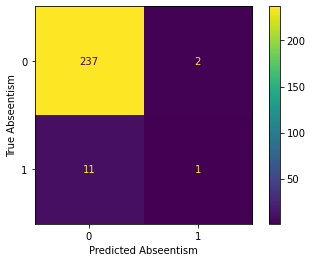

In [383]:
plot_confusion_matrix(clf, X_test, y_test) 
plt.xlabel('Predicted Abseentism')
plt.ylabel('True Abseentism')
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

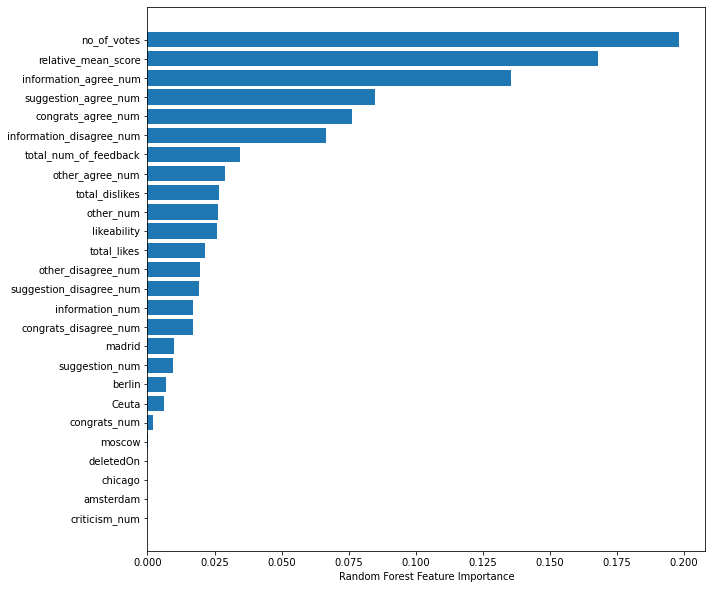

In [384]:
clf.feature_importances_
sorted_features = clf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(X.columns[sorted_features],clf.feature_importances_[sorted_features])
plt.xlabel("Random Forest Feature Importance")

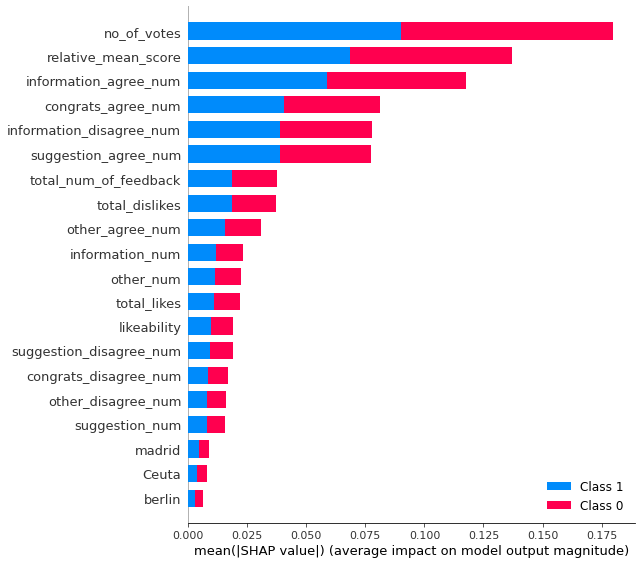

In [385]:
shap.summary_plot(shap_values, X_test_df)

In [386]:
# K fold cross validation
RFModel=RandomForestClassifier()
cv_method = KFold(n_splits = 10, shuffle = True, random_state = 2823)

svm_acc = np.mean(cross_val_score(RFModel, X, y ,cv = cv_method, scoring = 'accuracy'))
svm_recall = np.mean(cross_val_score(RFModel, X, y ,cv = cv_method, scoring = 'recall'))
svm_precision = np.mean(cross_val_score(RFModel, X, y ,cv = cv_method, scoring = 'precision'))

print('The Cross Validation Accuracy for Random Forest Model is ', svm_acc)
print('The Cross Validation Recall for Random Forest Model is ', svm_recall)
print('The Cross Validation Recall for Random Forest Model is ', svm_precision)

The Cross Validation Accuracy for Random Forest Model is  0.9486087205966722
The Cross Validation Recall for Random Forest Model is  0.16166666666666665
The Cross Validation Recall for Random Forest Model is  0.425


# Absent Tagging: more than 20 days

In [387]:
# convert the dataframe into a proper Y-like dataframe, i.e. employee id - month - label
Y_temp = pd.merge(emp_absen, temp2.rename(columns = {'num_days': 'ave_days'}), how = 'left')
Y_temp['Absence'] = Y_temp['num_days'] > 20 # Y_temp['ave_days']    ## open to change the benchmarking here ##
Y_2weeks = Y_temp[['employee', 'month', 'Absence']]
Y.head()

X1 = pd.merge(votes_X, commnet_X,  how = 'left')
print(X1.shape)
X = pd.merge(X1, inter_X, how = 'left')
print(X.shape)
final1 = pd.merge(X, Y_2weeks, how = 'left')
print(final1.shape)
final2 = pd.merge(final1, lastParticipationExists_v2, left_on = 'employee', right_on = 'employee',  how = 'left')
print(final2.shape)
final = final2.copy()

final['Absence'].fillna('False', inplace = True)
#final = final.drop(columns = ['employee', 'month'], axis = 1)
final['Absence'] = [1 if i == True else 0 for i in final['Absence']]
final = final[final['stillExists'] == True]

final['total_likes'].value_counts()

final['likeability'] = final['total_likes'] != 0
final['likeability'] = final['likeability'].astype(int)
final['likeability'] 

final.loc[final['total_likes']==0, 'likeability'] = 0 
final.loc[final['total_likes']!=0, 'likeability'] = final['total_likes']/(final['total_likes'] + final['total_dislikes'])

final['total_num_of_feedback'] = final['congrats_num'] + final['criticism_num'] + final['information_num'] + final['other_num'] + final['suggestion_num']
final['total_num_of_feedback']

final['relative_mean_score'] = final['mean_votes_score']/np.mean(final['mean_votes_score'])

final = final[['no_of_votes', 'congrats_num', 'criticism_num', 'information_num', 'other_num',
       'suggestion_num', 'total_likes', 'total_dislikes', 'congrats_agree_num', 'information_agree_num', 'other_agree_num', 
        'suggestion_agree_num', 'congrats_disagree_num', 'information_disagree_num', 'other_disagree_num', 
        'suggestion_disagree_num', 'deletedOn', 'Ceuta', 'chicago', 'amsterdam', 'berlin', 'madrid','moscow','Absence', 
               'likeability', 'total_num_of_feedback', 'relative_mean_score']]
            
final = final.fillna(0)
final

(897, 11)
(897, 19)
(902, 20)
(902, 35)


,no_of_votes,congrats_num,criticism_num,information_num,other_num,suggestion_num,total_likes,total_dislikes,congrats_agree_num,information_agree_num,...,Ceuta,chicago,amsterdam,berlin,madrid,moscow,Absence,likeability,total_num_of_feedback,relative_mean_score
0,25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,28.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
1,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
2,22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,23.0,...,0,0,0,1,0,0,0,0.0,0.0,0.351049
3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.053147
4,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,1,0,0,0.0,0.0,0.702098
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
896,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.404196
897,20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0,0,0,0,1,0,0,0.0,0.0,0.737203
899,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.053147
900,8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0.0,0.0,1.404196


In [388]:
#Class Imbalance
final['Absence'].value_counts()/(final['Absence'].value_counts()[0] + final['Absence'].value_counts()[1])

0    0.952153
1    0.047847
Name: Absence, dtype: float64

In [389]:
df = final.copy()

X = final.drop(columns = ['Absence'], axis = 1)
y = final['Absence']

X_stand = scale(X)

X_train, X_test, y_train, y_test = train_test_split(X_stand, y, test_size = 0.3, random_state = 0)
X_test_df = pd.DataFrame(X_stand)
X_test_df.columns = X.columns
X_test_df

oversample = RandomOverSampler(random_state=42, sampling_strategy=1)
#oversample = SMOTE(random_state=42, sampling_strategy=0.1)
X_res, y_res = oversample.fit_resample(X_train, y_train)

clf=RandomForestClassifier()

clf.fit(X_res, y_res)
y_pred=clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
#print('\n clasification report:\n', classification_report(y_test,y_pred))
print('\n confussion matrix:\n',confusion_matrix(y_test, y_pred))
import shap
explainer = shap.TreeExplainer(clf)
#svm_explainer = shap.TreeExplainer(clf.predict,X_test)
shap_values = explainer.shap_values(X_test)

Accuracy: 0.9163346613545816
Recall: 0.14285714285714285
Precision: 0.18181818181818182

 confussion matrix:
 [[228   9]
 [ 12   2]]


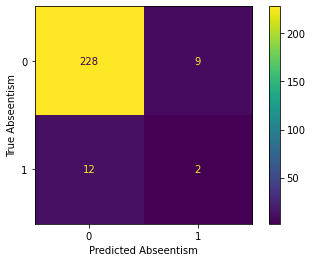

In [390]:
plot_confusion_matrix(clf, X_test, y_test) 
plt.xlabel('Predicted Abseentism')
plt.ylabel('True Abseentism')
plt.show()

Text(0.5, 0, 'Random Forest Feature Importance')

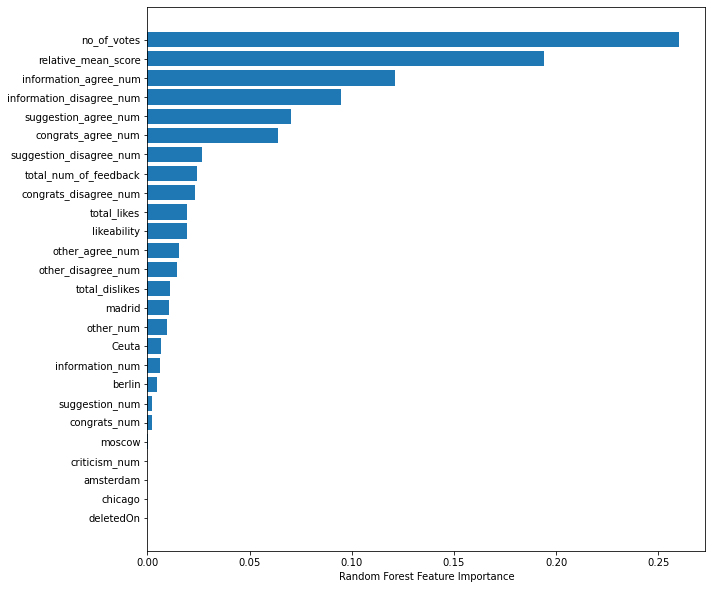

In [391]:
clf.feature_importances_
sorted_features = clf.feature_importances_.argsort()
plt.figure(figsize=(10,10))
plt.barh(X.columns[sorted_features],clf.feature_importances_[sorted_features])
plt.xlabel("Random Forest Feature Importance")

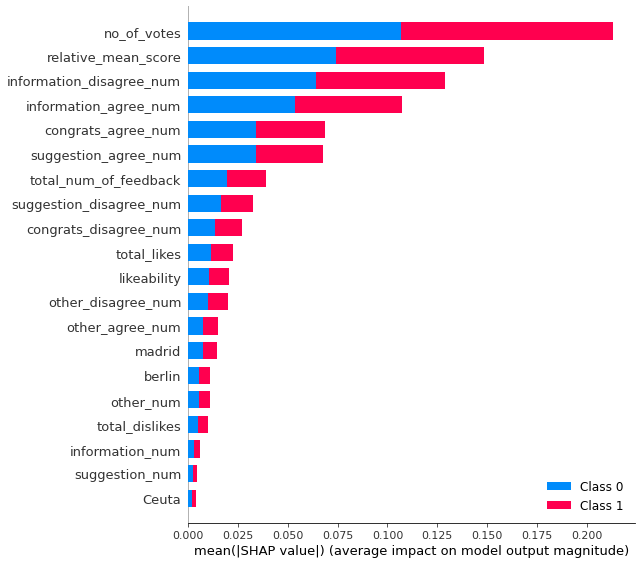

In [392]:
shap.summary_plot(shap_values, X_test_df)

In [393]:
# K fold cross validation
RFModel=RandomForestClassifier()
cv_method = KFold(n_splits = 10, shuffle = True, random_state = 2823)

svm_acc = np.mean(cross_val_score(RFModel, X, y ,cv = cv_method, scoring = 'accuracy'))
svm_recall = np.mean(cross_val_score(RFModel, X, y ,cv = cv_method, scoring = 'recall'))
svm_precision = np.mean(cross_val_score(RFModel, X, y ,cv = cv_method, scoring = 'precision'))

print('The Cross Validation Accuracy for Random Forest Model is ', svm_acc)
print('The Cross Validation Recall for Random Forest Model is ', svm_recall)
print('The Cross Validation Recall for Random Forest Model is ', svm_precision)

The Cross Validation Accuracy for Random Forest Model is  0.9498135398737807
The Cross Validation Recall for Random Forest Model is  0.04
The Cross Validation Recall for Random Forest Model is  0.2
